# Phase 5: ML Model Training

This notebook implements the steps for Phase 5: training a machine learning model to predict stock price movement.

In [6]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, RocCurveDisplay

## 1. Load Data

In [7]:
data_path = '../data/'
stock_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]
all_data_frames = []
column_names = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']

for stock_file in stock_files:
    stock_name = stock_file.replace('.csv', '')
    try:
        df = pd.read_csv(os.path.join(data_path, stock_file), header=0)
        if 'Date' not in df.columns:
             df = pd.read_csv(os.path.join(data_path, stock_file), skiprows=3, header=None, names=column_names)
    except Exception as e:
        print(f"Could not process {stock_file}. Error: {e}. Skipping file.")
        continue

    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date')
    df['Stock'] = stock_name
    all_data_frames.append(df)

combined_df = pd.concat(all_data_frames, ignore_index=True)
print(f"Loaded {len(combined_df)} rows of data.")

Loaded 2480 rows of data.


## 2. Feature Engineering

In [8]:
def create_features(df):
    df = df.sort_values(by=['Stock', 'Date'])
    # RSI
    delta = df.groupby('Stock')['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # MACD
    exp1 = df.groupby('Stock')['Close'].transform(lambda x: x.ewm(span=12, adjust=False).mean())
    exp2 = df.groupby('Stock')['Close'].transform(lambda x: x.ewm(span=26, adjust=False).mean())
    df['MACD'] = exp1 - exp2

    # Volume Change
    df['Volume_Change'] = df.groupby('Stock')['Volume'].transform(lambda x: x.diff())

    # Target variable: 1 if next day's close is higher, 0 otherwise
    df['Target'] = df.groupby('Stock')['Close'].transform(lambda x: (x.shift(-1) > x).astype(int))

    return df.dropna()

processed_df = create_features(combined_df.copy())
print("Features engineered successfully.")

Features engineered successfully.


## 3. Data Splitting

In [9]:
features = ['RSI', 'MACD', 'Volume_Change']
X = processed_df[features]
y = processed_df['Target']

# Using a chronological split for time-series data
train_size = int(len(processed_df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(f"Data split into {len(X_train)} training samples and {len(X_test)} testing samples.")

Data split into 1966 training samples and 492 testing samples.


## 4. Model Training and Hyperparameter Tuning

In [10]:
models = {
    'LogisticRegression': (LogisticRegression(random_state=42, solver='liblinear', max_iter=1000), {
        'C': [0.1, 1.0, 10.0],
        'penalty': ['l1', 'l2']
    }),
    'DecisionTree': (DecisionTreeClassifier(random_state=42), {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }),
    'RandomForest': (RandomForestClassifier(random_state=42), {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5]
    }),
    'XGBClassifier': (XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1]
    })
}


In [11]:
best_overall_model = None
best_overall_f1 = 0
best_overall_model_name = ''

In [12]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

for name, (model, params) in models.items():
    print(f"--- Tuning {name} ---")
    randomized_search = RandomizedSearchCV(
        model,
        params,
        n_iter=10,
        cv=5,
        scoring='f1',
        n_jobs=-1,
        random_state=42
    )
    randomized_search.fit(X_train, y_train)
    
    best_model = randomized_search.best_estimator_
    y_pred = best_model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Best parameters: {randomized_search.best_params_}")
    print(f"Tuned F1-Score: {f1:.4f}")

    if f1 > best_overall_f1:
        best_overall_f1 = f1
        best_overall_model = best_model
        best_overall_model_name = name

print(f"\nBest overall model is {best_overall_model_name} with an F1-Score of {best_overall_f1:.4f}")

--- Tuning LogisticRegression ---


c:\Users\Priyank\Documents\CODE\intern\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters: {'penalty': 'l1', 'C': 10.0}
Tuned F1-Score: 0.6379
--- Tuning DecisionTree ---
Best parameters: {'min_samples_split': 2, 'max_depth': None}
Tuned F1-Score: 0.5175
--- Tuning RandomForest ---
Best parameters: {'n_estimators': 200, 'min_samples_split': 5, 'max_depth': None}
Tuned F1-Score: 0.4805
--- Tuning XGBClassifier ---
Best parameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01}
Tuned F1-Score: 0.6298

Best overall model is LogisticRegression with an F1-Score of 0.6379


c:\Users\Priyank\Documents\CODE\intern\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:38:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## 5. Final Model Evaluation and Plotting

In [13]:
y_pred_final = best_overall_model.predict(X_test)
y_proba_final = best_overall_model.predict_proba(X_test)[:, 1]

final_accuracy = accuracy_score(y_test, y_pred_final)
final_precision = precision_score(y_test, y_pred_final)
final_f1 = f1_score(y_test, y_pred_final)
final_roc_auc = roc_auc_score(y_test, y_proba_final)

print(f"--- Final Performance for {best_overall_model_name} ---")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"F1-Score: {final_f1:.4f}")
print(f"ROC AUC: {final_roc_auc:.4f}")

--- Final Performance for LogisticRegression ---
Accuracy: 0.4878
Precision: 0.4847
F1-Score: 0.6379
ROC AUC: 0.5177


<Figure size 800x600 with 0 Axes>

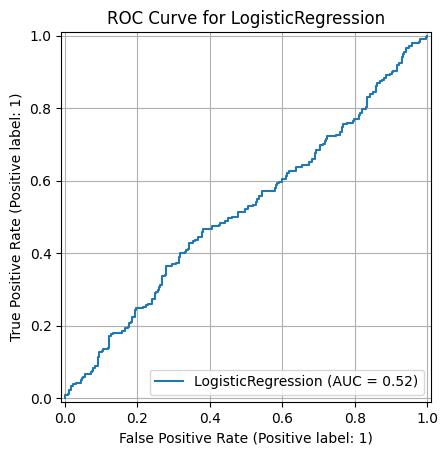

In [14]:
# Plotting ROC Curve
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(best_overall_model, X_test, y_test)
plt.title(f'ROC Curve for {best_overall_model_name}')
plt.grid(True)
plt.show()


C:\Users\Priyank\AppData\Local\Temp\ipykernel_24284\1564335207.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_names, y=metrics_values, palette='viridis')


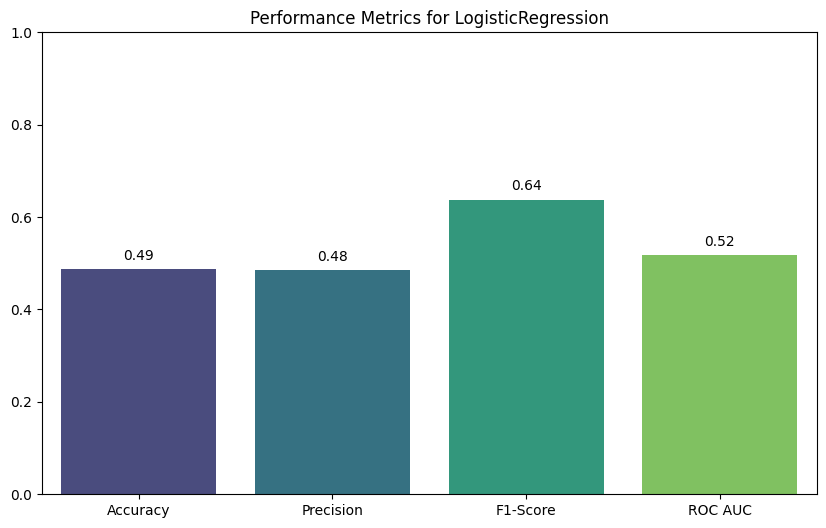

In [15]:

# Plotting performance metrics
metrics_names = ['Accuracy', 'Precision', 'F1-Score', 'ROC AUC']
metrics_values = [final_accuracy, final_precision, final_f1, final_roc_auc]

plt.figure(figsize=(10, 6))
sns.barplot(x=metrics_names, y=metrics_values, palette='viridis')
plt.title(f'Performance Metrics for {best_overall_model_name}')
plt.ylim(0, 1)
for index, value in enumerate(metrics_values):
    plt.text(index, value + 0.02, f'{value:.2f}', ha='center')
plt.show()

## 6. Saving the Best Model

In [16]:
import pickle
import os

In [17]:
models_dir = '../models/'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

model_filename = os.path.join(models_dir, 'best_model.pkl')
with open(model_filename, 'wb') as f:
    pickle.dump(best_overall_model, f)
print(f"Saved best model ({best_overall_model_name}) to {model_filename}")

Saved best model (LogisticRegression) to ../models/best_model.pkl
